<a href="https://colab.research.google.com/github/yurigalindo/PyTorchSamples/blob/main/Colab%20Notebooks/Calibrated_confidence_thresholding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
%%capture
!unzip /content/gdrive/My\ Drive/Meteoros -d IC
!unzip /content/gdrive/My\ Drive/iconip_csvs -d IC

In [ ]:
#General imports
from __future__ import print_function, division 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from skimage import io, transform
from PIL import ImageFile
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
#Utilities for loading the images and creating datasets

import os
import os.path
from torch.utils.data import Dataset
from torchvision import get_image_backend

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

def default_loader(path):
  if get_image_backend() == 'accimage':
    return accimage_loader(path)
  else:
    return pil_loader(path)
def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
      return pil_loader(path)

class ImageFromCSV(Dataset):
    """Class for creating an image dataset based on a csv with filenames and
    a directory containing the images
    """

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.csv.iloc[idx, 0])
        image = default_loader(img_name)
        label = self.csv.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image , label

In [ ]:
#Creation of datasets

#Transforms to convert the input into the input expected by resnet
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'calib': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

#Creates datasets and stores them in a dictionary
image_datasets = dict()

for fold in range(4):
  image_datasets[fold] = {x:ImageFromCSV("IC/iconip_csvs/{0}_calib{1}.csv".format(x,fold+1),"IC/Meteoros",transform=data_transforms[x])
                  for x in ['train', 'valid','test','calib']}

In [ ]:
print(image_datasets)

{0: {'train': <__main__.ImageFromCSV object at 0x7f28559b3828>, 'valid': <__main__.ImageFromCSV object at 0x7f28b64aa9e8>, 'test': <__main__.ImageFromCSV object at 0x7f28c8d1da58>, 'calib': <__main__.ImageFromCSV object at 0x7f28ce74fb70>}, 1: {'train': <__main__.ImageFromCSV object at 0x7f28559b37f0>, 'valid': <__main__.ImageFromCSV object at 0x7f28559b3ac8>, 'test': <__main__.ImageFromCSV object at 0x7f28559b3be0>, 'calib': <__main__.ImageFromCSV object at 0x7f28559b3cf8>}, 2: {'train': <__main__.ImageFromCSV object at 0x7f28559b3e10>, 'valid': <__main__.ImageFromCSV object at 0x7f28559b3f28>, 'test': <__main__.ImageFromCSV object at 0x7f285589b0b8>, 'calib': <__main__.ImageFromCSV object at 0x7f285589b198>}}


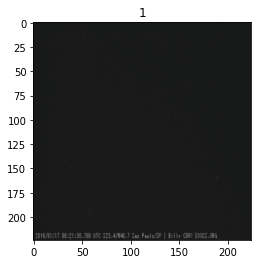

In [ ]:
#Displaying one image from the dataset for debugging purposes
dataloader=torch.utils.data.DataLoader(image_datasets[1]['train'])
plt.ion() 
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloader))


# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=classes.item())

In [ ]:
import matplotlib.pyplot as plt
import torch

class Learner:
    """Class for wrapping a model with training and prediction functionality.
    Stores an optimizer, a training criterion, and datasets. These can be altered
    throught set functions.
    """
    def __init__(self,model,criterion):
        self.model=model
        self.criterion=criterion
        self.device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.best_acc=0
        self.last_acc=0

    def set_datasets(self,training,valid):
        self.training_dataset=training
        self.validation_dataset=valid
    def set_optimizer(self,optimizer,scheduler):
        self.optimizer=optimizer
        self.scheduler=scheduler
    def propagate_batch(self,inputs,labels):
        with torch.set_grad_enabled(True):
            outputs=self.model(inputs)
            size=inputs.size(0)
            del inputs
            loss = self.criterion(outputs, labels)
            loss.backward()
            
        with torch.no_grad():
            preds = torch.argmax(outputs, 1)
            corrects = torch.sum(preds==labels.data).item() 
            loss_item=loss.item()
        del preds
        del outputs
        del loss
        del labels
        return loss_item*size,corrects

    def eval_batch(self, inputs, labels):
        with torch.no_grad():
            outputs=self.model(inputs)
            loss = self.criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
            corrects = torch.sum(preds==labels.data).item()
            size=inputs.size(0)
            loss_item=loss.item()
        del outputs
        del loss
        del preds
        del inputs
        del labels
        return loss_item*size,corrects

    def print_statistics(self,loss,accuracy):
        print("  Avg Loss={}\n  Accuracy={}".format(loss,accuracy))
    def ceildiv(self,a, b):
        """Return the celing of the division of a by b
        """
        return -(-a // b)
    def min_value(self,a,b):
        """Return the smaller of two values
        """
        if a>b:
            return b
        else:
            return a
    def max_value(self,a,b):
        """"Return the greater of two values
        """
        if b>a:
          return b
        else:
          return a
    def change_to_best_model(self):
        self.model.load_state_dict(self.best_model_wts)
    def train(self,num_epochs,training_batchsize,validation_batchsize,batch_cap=32,verbose=True):
        """Train the learner's model for num_epochs on training batchsize, printing the train and validation loss and accuracy
        """
        batch_cap=self.min_value(training_batchsize,batch_cap)
        train_dataloader=torch.utils.data.DataLoader(self.training_dataset,batch_size=batch_cap,shuffle=True)
        
        training_batches=self.ceildiv(len(self.training_dataset),training_batchsize)
        micro_batches=training_batchsize//batch_cap #accuracy statistics will only work properly if training batch is divisible by batch_cap
        valid_dataloader=torch.utils.data.DataLoader(self.validation_dataset,batch_size=validation_batchsize,shuffle=True)
        validation_batches=self.ceildiv(len(self.validation_dataset),validation_batchsize)
        since = time.time()
        train_losses=[]
        valid_losses=[]
        for epoch in range(num_epochs):
            if verbose:
              print("Epoch {} of {}".format(epoch,num_epochs-1))
            
            

            self.model.train()
            #Train model
            loss = 0
            corrects = 0
            iterator = iter(train_dataloader)
            for batch in range(training_batches):
                self.optimizer.zero_grad()
                try:
                  for micro_batch in range(micro_batches):

                    inputs,labels=next(iterator)
                    new_loss , new_corrects = self.propagate_batch(inputs.to(self.device),labels.to(self.device))
                    loss+=new_loss
                    corrects+=new_corrects
                    del inputs
                    del labels
                    del new_loss
                    del new_corrects
                    torch.cuda.empty_cache()
                except StopIteration:
                    pass
                self.optimizer.step()
                torch.cuda.empty_cache()

            self.scheduler.step()
            optimizer.zero_grad()
            torch.cuda.empty_cache()
            train_losses.append(loss/len(self.training_dataset))
            if verbose:
              print("Training:")
              self.print_statistics(loss/len(self.training_dataset),corrects/len(self.training_dataset))
            
            
            self.model.eval()
            #Evaluate model
            loss = 0
            corrects = 0
            iterator = iter(valid_dataloader)
            for batch in range(validation_batches):
                inputs,labels=next(iterator)
                new_loss , new_corrects=self.eval_batch(inputs.to(self.device),labels.to(self.device))
                loss+=new_loss
                corrects+=new_corrects
                del inputs
                del labels
                del new_loss
                del new_corrects
                torch.cuda.empty_cache()
            valid_losses.append(loss/len(self.validation_dataset))
            acc=corrects/len(self.validation_dataset)
            if verbose:
              print("Validation:")
              self.print_statistics(loss/len(self.validation_dataset),acc)
              print()
            self.last_acc=acc
            if(acc>self.best_acc):
              self.best_acc=acc
              self.best_model_wts = copy.deepcopy(self.model.state_dict())
            

        time_elapsed = time.time() - since
        print("Total time:{}".format(time_elapsed))
        plt.plot(range(num_epochs),train_losses,'r',range(num_epochs),valid_losses,'b')
        del train_dataloader
        del valid_dataloader
        del train_losses
        del valid_losses
        torch.cuda.empty_cache()
    def predict(self,dataset,batchsize,num_classes):
        """Predicts on a dataset and returns a tensor containing the probabilities of each class 
        """
        dataloader=torch.utils.data.DataLoader(dataset,batch_size=batchsize,shuffle=False)
        dataset_len=len(dataset)
        num_batches=self.ceildiv(dataset_len,batchsize)
        since = time.time()
        predictions = torch.zeros((len(dataset),num_classes)).to(self.device)
        self.model.eval()
        self.optimizer.zero_grad()
        iterator = iter(dataloader)
        with torch.no_grad():
          for batch in range(num_batches):
              inputs, _ = next(iterator)
              inputs = inputs.to(self.device)
              logits =  self.model(inputs)
              del inputs
              unnormalized_probabilities = torch.exp(logits)
              del logits
              denominators = torch.sum(unnormalized_probabilities,1,True)
              probabilities= torch.div(unnormalized_probabilities,denominators)
              del denominators
              del unnormalized_probabilities
              indexes=torch.tensor(range(batch*batchsize,self.min_value((batch+1)*batchsize,dataset_len))).to(self.device)
              predictions.index_copy_(0,indexes,probabilities)
              del indexes
              del probabilities
              torch.cuda.empty_cache()
          predictions_cpu=predictions.cpu()
        del predictions
        del dataloader
        torch.cuda.empty_cache()
        return predictions_cpu

In [ ]:
import torch
from torch import nn, optim
from torch.nn import functional as F


class ModelWithTemperature(nn.Module):
    """
    A thin decorator, which wraps a model with temperature scaling
    model (nn.Module):
        A classification neural network
        NB: Output of the neural network should be the classification logits,
            NOT the softmax (or log softmax)!
    """
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, input):
        logits = self.model(input)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        """
        Perform temperature scaling on logits
        """
        # Expand temperature to match the size of logits
        temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        return logits / temperature

    # This function probably should live outside of this class, but whatever
    def set_temperature(self, valid_loader):
        """
        Tune the tempearature of the model (using the validation set).
        We're going to set it to optimize NLL.
        valid_loader (DataLoader): validation set loader
        """
        self.cuda()
        nll_criterion = nn.CrossEntropyLoss().cuda()
        ece_criterion = _ECELoss().cuda()

        # First: collect all the logits and labels for the validation set
        logits_list = []
        labels_list = []
        with torch.no_grad():
            for input, label in valid_loader:
                input = input.cuda()
                logits = self.model(input)
                logits_list.append(logits)
                labels_list.append(label)
            logits = torch.cat(logits_list).cuda()
            labels = torch.cat(labels_list).cuda()
        

        # Next: optimize the temperature w.r.t. NLL
        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=1e3)

        def eval():
            loss = nll_criterion(self.temperature_scale(logits), labels)
            optimizer.zero_grad()
            loss.backward()
            return loss
        optimizer.step(eval)



class _ECELoss(nn.Module):
    """
    Calculates the Expected Calibration Error of a model.
    (This isn't necessary for temperature scaling, just a cool metric).
    The input to this loss is the logits of a model, NOT the softmax scores.
    This divides the confidence outputs into equally-sized interval bins.
    In each bin, we compute the confidence gap:
    bin_gap = | avg_confidence_in_bin - accuracy_in_bin |
    We then return a weighted average of the gaps, based on the number
    of samples in each bin
    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    """
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, logits, labels):
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        ece = torch.zeros(1, device=logits.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece

In [ ]:
def freeze_resnet(model,n):
  """Function that freezes the first n layers of a resnet
  """
  #This is considered as the first layer
  model.conv1.requires_grad=False
  model.bn1.weight.requires_grad=False
  model.bn1.bias.requires_grad=False
  l=1
  flag=False #Flag for stopping the iteration
  for layer in [model.layer1,model.layer2,model.layer3,model.layer4]:
    #Resnets group the layers on these 4 layer blocks
    if(flag):
      break
    for block in layer:
      if(flag):
        break
      for module in block.children():
        if(l<n):
          #Code for making the conv and batch norm layers untrainable
          if isinstance(module,nn.Conv2d):
            module.requires_grad=False
          elif isinstance(module,nn.BatchNorm2d):
            module.weight.requires_grad=False
            module.bias.requires_grad=False
            l+=1 #Counts each conv + batch group as one layer
        else:
          flag=True
          break


In [ ]:
def accuracy_confidence(predictions,labels,threshold=0.5):
  """Given a confidence threshold, takes into account only the predictions above the threshold
  and evaluates accuracy, precision, recall and coverage
  """
  threshold = min(threshold,1-threshold)
  clip_preds = predictions.copy()
  clip_preds[clip_preds>=0.5]=1
  clip_preds[clip_preds<0.5]=0
  mask = np.logical_or(predictions<=threshold,predictions>=1-threshold) #mask for predictions above the threshold
  predicted = mask.sum()
  right_answers = clip_preds == labels
  right_answers[np.logical_not(mask)] = False #answers that were not predicted are not counted as correct
  correct = right_answers.sum()
  if predicted == 0:
    acc =0
  else:
    acc = correct/predicted

  predicted_meteors = clip_preds == 0
  predicted_meteors[np.logical_not(mask)] = False #removing meteors not predicted on
  true_positives = right_answers[predicted_meteors].sum()
  if true_positives == 0:
    precision = recall = 0
  else:
    precision = true_positives/predicted_meteors.sum()
    true_meteors = labels == 0
    true_meteors[np.logical_not(mask)] = False #disconsider the true meteors not predicted on
    recall = true_positives/true_meteors.sum()

  coverage = predicted/len(labels)
  return {'acc':acc ,'cov': coverage , 'prec':precision , 'rec':recall}
  


Total time:1647.863749742508
Uncalibrated:
Brier score:0.19939816796995904 
Cross entropy: 1.3681894874981682
0.01
{'acc': 0.8238297872340425, 'cov': 0.8508327299058653, 'prec': 0.77375, 'rec': 0.9596899224806201}
0.05
{'acc': 0.808, 'cov': 0.9051412020275162, 'prec': 0.7624703087885986, 'rec': 0.9413489736070382}
0.1
{'acc': 0.8043818466353677, 'cov': 0.9254163649529327, 'prec': 0.7579318448883666, 'rec': 0.9361393323657474}
0.15
{'acc': 0.7989255564082886, 'cov': 0.943519188993483, 'prec': 0.7529002320185615, 'rec': 0.9297994269340975}
0.2
{'acc': 0.8, 'cov': 0.9522085445329471, 'prec': 0.7520278099652375, 'rec': 0.9297994269340975}
0.25
{'acc': 0.7984905660377358, 'cov': 0.9594496741491673, 'prec': 0.7491369390103567, 'rec': 0.93}
0.3
{'acc': 0.793591654247392, 'cov': 0.9717595944967415, 'prec': 0.7434435575826682, 'rec': 0.9261363636363636}
0.5
{'acc': 0.7871107892831282, 'cov': 1.0, 'prec': 0.7371364653243848, 'rec': 0.9178272980501393}

Isotonic fit:
Brier score:0.191072206689352

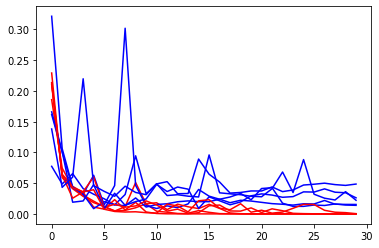

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from sklearn import linear_model
from sklearn import metrics
from sklearn.isotonic import IsotonicRegression
from sklearn import calibration


for fold in range(3,4): #3 different divisions
  for _ in range(5): #3 different initializations
    #Initializing the model with the hyperparameters
    model_ft = models.resnet50(pretrained=True)
    freeze_resnet(model_ft,33)
    num_ftrs=model_ft.fc.in_features
    model_ft.fc=nn.Sequential(  nn.Linear(num_ftrs, 1024),
                                nn.ReLU(),
                                nn.Linear(1024, 2),
                            )
    model_ft=model_ft.to(device)
    criterion = nn.CrossEntropyLoss()
    learner = Learner(model_ft,criterion)

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr = 3e-4)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer,0.99)
    learner.set_optimizer(optimizer,scheduler)

    #Training for 30 epochs then changing to the best model on the validation (early stopping)
    learner.set_datasets(image_datasets[fold]['train'],image_datasets[fold]['valid'])
    learner.train(30,64,128,batch_cap=64,verbose=False)
    learner.change_to_best_model()

    #Extracting labels and predictions for calibration and test sets
    calib_preds = learner.predict(image_datasets[fold]['calib'],128,2)
    calib_preds[torch.isnan(calib_preds)]=1 #Some extremely glitched inputs may result in nan output,
                                            #these can be discardes as non meteors.
    calib_preds = calib_preds[:,1].numpy() #Predicted probability of being non meteor
    calib_labels = np.array([image_datasets[fold]['calib'][i][1] for i in range(len(image_datasets[fold]['calib']))])

    test_preds = learner.predict(image_datasets[fold]['test'],128,2)
    test_preds[torch.isnan(test_preds)]=1
    test_preds = test_preds[:,1].numpy()
    test_labels = np.array([image_datasets[fold]['test'][i][1] for i in range(len(image_datasets[fold]['test']))])

    #Fitting isotonic model on top of the predictions on calibration set
    ir = IsotonicRegression(out_of_bounds='clip')
    ir.fit(calib_preds,calib_labels)

    print("Uncalibrated:")
    print("Brier score:{0} \nCross entropy: {1}".format(metrics.brier_score_loss(test_labels,test_preds),metrics.log_loss(test_labels,test_preds,eps=1e-7)))
    for t in [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.5]:
      print (t)
      print(accuracy_confidence(test_preds,test_labels,t))
    
    print()
    print("Isotonic fit:")
    print("Brier score:{0} \nCross entropy: {1}".format(metrics.brier_score_loss(test_labels,ir.predict(test_preds)),metrics.log_loss(test_labels,ir.predict(test_preds),eps=1e-7),ir.predict(test_preds)))
    for t in [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.5]:
      print (t)
      print(accuracy_confidence(ir.predict(test_preds),test_labels,t))
    print()

    calibrated_model = ModelWithTemperature(learner.model)
    calibrated_model.set_temperature(torch.utils.data.DataLoader(image_datasets[fold]['calib'],batch_size=64))
    learner.model=calibrated_model

    test_preds = learner.predict(image_datasets[fold]['test'],128,2)
    test_preds[torch.isnan(test_preds)]=1
    test_preds = test_preds[:,1].numpy()

    print("Temperature calibrated:")
    print("Test set:")
    print("Brier score:{0} \nCross entropy: {1}".format(metrics.brier_score_loss(test_labels,test_preds),metrics.log_loss(test_labels,test_preds,eps=1e-7)))
    for t in [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.5]:
      print (t)
      print(accuracy_confidence(test_preds,test_labels,t))
    print()




Total time:1618.5451204776764
Temperature calibrated:
Test set:
Brier score:0.0794991781081873 
Cross entropy: 0.2784561052983913
0.01
{'acc': 0.986870897155361, 'cov': 0.3121584699453552, 'prec': 0.98, 'rec': 0.98989898989899}
0.05
{'acc': 0.9650485436893204, 'cov': 0.703551912568306, 'prec': 0.9581939799331104, 'rec': 0.9811643835616438}
0.1
{'acc': 0.9518174133558749, 'cov': 0.8080601092896175, 'prec': 0.9439775910364145, 'rec': 0.975397973950796}
0.15
{'acc': 0.9389373513084853, 'cov': 0.8613387978142076, 'prec': 0.927741935483871, 'rec': 0.9716216216216216}
0.2
{'acc': 0.93353705118411, 'cov': 0.8941256830601093, 'prec': 0.9219330855018587, 'rec': 0.96875}
0.25
{'acc': 0.9284649776453056, 'cov': 0.9166666666666666, 'prec': 0.9154589371980676, 'rec': 0.9668367346938775}
0.3
{'acc': 0.9217836257309941, 'cov': 0.9344262295081968, 'prec': 0.9044811320754716, 'rec': 0.9672131147540983}
0.5
{'acc': 0.8941256830601093, 'cov': 1.0, 'prec': 0.877665544332211, 'rec': 0.9444444444444444}

To

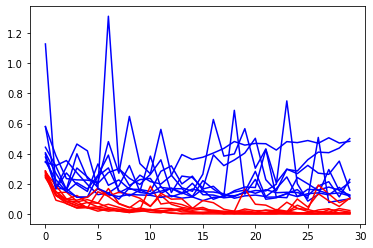

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from sklearn import linear_model
from sklearn import metrics
from sklearn.isotonic import IsotonicRegression
from sklearn import calibration


for fold in range(3): #3 different divisions
  for _ in range(3): #3 different initializations
    #Initializing the model with the hyperparameters
    model_ft = models.resnet50(pretrained=True)
    freeze_resnet(model_ft,33)
    num_ftrs=model_ft.fc.in_features
    model_ft.fc=nn.Sequential(  nn.Linear(num_ftrs, 1024),
                                nn.ReLU(),
                                nn.Linear(1024, 2),
                            )
    model_ft=model_ft.to(device)
    criterion = nn.CrossEntropyLoss()
    learner = Learner(model_ft,criterion)

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr = 3e-4)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer,0.99)
    learner.set_optimizer(optimizer,scheduler)

    #Training for 30 epochs then changing to the best model on the validation (early stopping)
    learner.set_datasets(image_datasets[fold]['train'],image_datasets[fold]['valid'])
    learner.train(30,64,128,batch_cap=64,verbose=False)
    learner.change_to_best_model()

    
    test_labels = np.array([image_datasets[fold]['test'][i][1] for i in range(len(image_datasets[fold]['test']))])
   
    calibrated_model = ModelWithTemperature(learner.model)
    calibrated_model.set_temperature(torch.utils.data.DataLoader(image_datasets[fold]['calib'],batch_size=64))
    learner.model=calibrated_model

    test_preds = learner.predict(image_datasets[fold]['test'],128,2)
    test_preds[torch.isnan(test_preds)]=1
    test_preds = test_preds[:,1].numpy()

    print("Temperature calibrated:")
    print("Test set:")
    print("Brier score:{0} \nCross entropy: {1}".format(metrics.brier_score_loss(test_labels,test_preds),metrics.log_loss(test_labels,test_preds,eps=1e-7)))
    for t in [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.5]:
      print (t)
      print(accuracy_confidence(test_preds,test_labels,t))
    
    print()

    





In [ ]:
loss = _ECELoss()
print (loss(torch.Tensor(ir.predict(test_preds)),torch.tensor(test_labels)))

AttributeError: ignored

In [ ]:
calibrated_model = ModelWithTemperature(learner.model)
calibrated_model.set_temperature(torch.utils.data.DataLoader(image_datasets['calib'],batch_size=64))

Before temperature - NLL: 0.404, ECE: 0.078
Optimal temperature: 2.344
After temperature - NLL: 0.295, ECE: 0.024


ModelWithTemperature(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [ ]:
new_learner=Learner(calibrated_model,criterion)
temperature_calib_preds = new_learner.predict(image_datasets['calib'],128,2)
temperature_calib_preds = temperature_calib_preds[:,1].numpy()

temperature_test_preds = learner.predict(image_datasets['test'],128,2)
temperature_test_preds = temperature_test_preds[:,1].numpy()

0.40388116652413997
0.2948497999688255


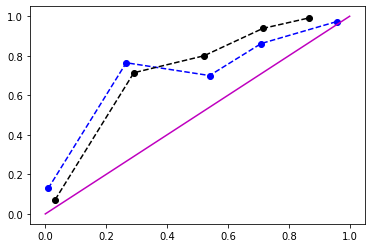

In [ ]:
print(metrics.log_loss(calib_labels,
                       calib_preds,eps=1e-7))
print(metrics.log_loss(calib_labels,
                       temperature_calib_preds,eps=1e-7))
y1,x1 =  calibration.calibration_curve( calib_labels, calib_preds, normalize=False, n_bins=5)
y2,x2 =  calibration.calibration_curve( calib_labels, temperature_calib_preds, normalize=False, n_bins=5)
plt.plot(x1,y1,'bo--',x2,y2,'ko--',[0,1],[0,1],'m')

0.4417057817749862
0.4417057817749862


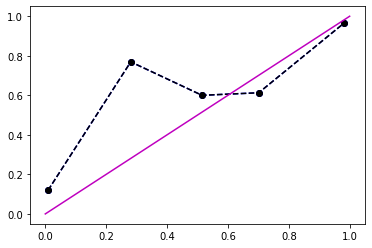

In [ ]:

print(metrics.log_loss(test_labels,
                       test_preds,eps=1e-7))
print(metrics.log_loss(test_labels,
                       temperature_test_preds,eps=1e-7))
y1,x1 =  calibration.calibration_curve( test_labels, test_preds, normalize=False, n_bins=5)
y2,x2 =  calibration.calibration_curve( test_labels, temperature_test_preds, normalize=False, n_bins=5)
plt.plot(x1,y1,'bo--',x2,y2,'ko--',[0,1],[0,1],'m')

In [ ]:
data = [accuracy_confidence(temperature_test_preds,test_labels,t) for t in [0.05,0.1,0.2,0.3,0.4,0.5]]
acc = [x[0] for x in data]
cov = [x[1] for x in data]
print(acc)
print(cov)